In [1]:
import pandas as pd
import numpy as np

In [24]:
test = pd.read_hdf('test.h5','data')
train = pd.read_hdf('train.h5','data')

In [25]:
eventmap = {'cart':5, 'purchase':10, 'remove_from_cart':-5, 'view':1}

In [26]:
plen = 200
tlen = 200
def transferTrain(df,eventmap):
    gr = df.groupby('user_id').filter(lambda x: len(x)>=5).groupby('user_id')
    xtrain = np.zeros((len(gr),tlen, plen*4))
    ytrain = np.zeros(len(gr),dtype=int)
    yreal = np.zeros((len(gr),plen),dtype=int)
    for i,(usr_id,ur) in enumerate(gr):
        urlen = len(ur)
        predict = ur.iloc[-1]['product_id']
        if np.where(ur.iloc[-np.min([tlen+1,urlen]):-1]['product_id']==predict)[0].shape[0]==0:
            predict = ur.iloc[-2]['product_id']
        products = np.unique(ur.iloc[-np.min([tlen+1,urlen]):-1]['product_id'])
        productsmap = {}
        for pi,p in enumerate(products):
            productsmap[p] = pi
        ytrain[i] = productsmap[predict]
        for k,(_,upr) in enumerate(ur.iloc[-np.min([tlen+1,urlen]):-1].iterrows()):
            et = upr['event_type']
            j = productsmap[upr['product_id']]
            if et==eventmap['cart']:
                xtrain[i,k,j*4+0] =1
            elif et==eventmap['purchase']:
                xtrain[i,k,j*4+1] =1
            elif et==eventmap['remove_from_cart']:
                xtrain[i,k,j*4+2] =1
            elif et==eventmap['view']:
                xtrain[i,k,j*4+3] =1   
            yreal[i][j] = upr['product_id']
            if j>=(plen-1):
                break
        yreal[i][(j+1):] = ur.iloc[-2]['product_id']
        #if i>2:
        #    break
    return xtrain,ytrain,yreal
def transferTest(df,eventmap):
    gr = df.groupby('user_id')
    xtrain = np.zeros((len(gr),tlen, plen*4))
    yreal = np.zeros((len(gr),plen),dtype=int)
    for i,(usr_id,ur) in enumerate(gr):
        urlen = len(ur)
        products = np.unique(ur.iloc[-np.min([tlen,urlen]):]['product_id'])
        productsmap = {}
        for pi,p in enumerate(products):
            productsmap[p] = pi
        for k,(_,upr) in enumerate(ur.iloc[-np.min([tlen,urlen]):].iterrows()):
            et = upr['event_type']
            j = productsmap[upr['product_id']]
        
            if et==eventmap['cart']:
                xtrain[i,k,j*4+0] =1
            elif et==eventmap['purchase']:
                xtrain[i,k,j*4+1] =1
            elif et==eventmap['remove_from_cart']:
                xtrain[i,k,j*4+2] =1
            elif et==eventmap['view']:
                xtrain[i,k,j*4+3] =1   
            yreal[i][j] = upr['product_id']
        yreal[i][(j+1):] = ur.iloc[-1]['product_id']
        #if i>2:
        #    break
    return xtrain,yreal

In [27]:
xtest,ytestreal=transferTest(test,eventmap)

In [56]:
xtrain,ytrain,ytrainreal=transferTrain(train,eventmap)

In [54]:
%debug

> <ipython-input-51-ca3267e2e1f7>(17)transferTrain()
     15         for pi,p in enumerate(products):
     16             productsmap[p] = pi
---> 17         ytrain[i] = productsmap[predict]
     18         for k,(_,upr) in enumerate(ur.iloc[-np.min([tlen+1,urlen]):-1].iterrows()):
     19             et = upr['event_type']



ipdb>  predict


5787561


ipdb>  productsmap


{4938: 0, 5013: 1, 6977: 2, 6978: 3, 8098: 4, 5561488: 5, 5700039: 6, 5712801: 7, 5716556: 8, 5730207: 9, 5734477: 10, 5734534: 11, 5734569: 12, 5736189: 13, 5736325: 14, 5736501: 15, 5742401: 16, 5744388: 17, 5763413: 18, 5774340: 19, 5780927: 20, 5783547: 21, 5784039: 22, 5784570: 23, 5788712: 24, 5792800: 25, 5793704: 26, 5802649: 27, 5809912: 28, 5810145: 29, 5817702: 30, 5837635: 31, 5843546: 32, 5849033: 33, 5853536: 34, 5853698: 35, 5853712: 36, 5853713: 37, 5854897: 38, 5857360: 39}


ipdb>  ur.iloc[-1]


event_time     2019-10-04 06:50:48 UTC
event_type                          10
product_id                     5787561
category_id                        166
price                             3.97
user_id                           3226
Name: 46368, dtype: object


ipdb>  exit


In [57]:
import h5py
with h5py.File('train2.h5','w') as opt:
    opt.create_dataset('x',data=xtrain,compression='gzip')
    opt.create_dataset('y', data=ytrain,compression='gzip')
    opt.create_dataset('test', data=xtest,compression='gzip')
    opt.create_dataset('yreal',data=ytrainreal,compression='gzip')
    opt.create_dataset('ytestreal',data=ytestreal,compression='gzip')

In [2]:
import h5py
with h5py.File('train2.h5','r') as ipt:
    xtrain = ipt['x'][:]
    ytrain = ipt['y'][:]
    ytrainreal = ipt['yreal']
    xtest = ipt['test'][:]
    ytestreal = ipt['ytestreal'][:]

(10099,)


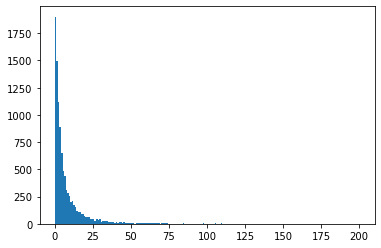

In [14]:
import matplotlib.pyplot as plt
plt.hist(ytrain,range=[0,200],bins=200)
print(ytrain.shape)

In [3]:
import torch
from torch import nn
import torch.optim as optim
import torch.utils.data as Data
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [5]:
plen = 200
tlen = 200
x_train = torch.from_numpy(xtrain).view(-1,tlen,plen*4).cuda()
y_train = torch.from_numpy(ytrain).view(-1).cuda()
x_test = torch.from_numpy(xtest).view(-1,tlen,plen*4).cuda()

In [6]:
print(xtrain.shape,ytrain.shape)

(10099, 200, 800) (10099,)


In [7]:
batch_size=512
train_dataset = Data.TensorDataset(x_train[:7000],y_train[:7000])
train_loader = Data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=False)
test_dataset = Data.TensorDataset(x_train[7000:],y_train[7000:])
test_loader = Data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False)

In [15]:
class Net(torch.nn.Module):
    def __init__(self, input_size=800,hidden_size=16,out_size=200,num_layers=4):
        super(Net, self).__init__()
        self.rnn = nn.LSTM(
            input_size=input_size,
            hidden_size = hidden_size,
            num_layers = num_layers,
            batch_first = True
        )
        self.out = nn.Linear(hidden_size, out_size)
    def forward(self, x):
        rout, (hn,hc) = self.rnn(x,None)
        x = self.out(rout)
        return x
model = Net().to(device)

In [16]:
learning_rate=0.01
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#criterion = nn.MSELoss()
criterion=nn.CrossEntropyLoss()

In [17]:
epochs = 64
for epoch in range(epochs):
    model.train()
    for batch,(x,y) in enumerate(train_loader):
        ypred = model(x.float())
        ypred = ypred[:,-1,:]
        #print(ypred.shape,y.shape)
        loss = criterion(ypred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    model.eval()
    size = len(test_loader.dataset)
    test_loss, correct = 0,0
    with torch.no_grad():
        for x,y in test_loader:
            x = x.float()
            pred = model(x)
            pred = pred[:,-1,:]
            test_loss += criterion(pred,y).item()
            correct += (pred.argmax(1) ==y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f'Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss:{test_loss:>8f} \n')

Test Error: 
 Accuracy: 19.7%, Avg loss:0.023206 

Test Error: 
 Accuracy: 19.7%, Avg loss:0.023202 

Test Error: 
 Accuracy: 19.7%, Avg loss:0.023198 

Test Error: 
 Accuracy: 19.7%, Avg loss:0.023198 

Test Error: 
 Accuracy: 19.7%, Avg loss:0.023199 

Test Error: 
 Accuracy: 19.7%, Avg loss:0.023200 

Test Error: 
 Accuracy: 19.7%, Avg loss:0.023202 

Test Error: 
 Accuracy: 19.7%, Avg loss:0.023202 

Test Error: 
 Accuracy: 19.7%, Avg loss:0.023192 

Test Error: 
 Accuracy: 19.7%, Avg loss:0.023188 

Test Error: 
 Accuracy: 19.7%, Avg loss:0.023188 

Test Error: 
 Accuracy: 19.7%, Avg loss:0.023187 

Test Error: 
 Accuracy: 19.7%, Avg loss:0.023186 

Test Error: 
 Accuracy: 19.7%, Avg loss:0.023181 

Test Error: 
 Accuracy: 19.7%, Avg loss:0.023172 

Test Error: 
 Accuracy: 19.7%, Avg loss:0.023163 

Test Error: 
 Accuracy: 19.7%, Avg loss:0.023158 

Test Error: 
 Accuracy: 19.7%, Avg loss:0.023158 

Test Error: 
 Accuracy: 19.7%, Avg loss:0.023161 

Test Error: 
 Accuracy: 19.7%, 

In [31]:
model.eval()
with torch.no_grad():
    x_test = x_test.float()
    predO = model(x_test)
    predO=predO[:,-1,:]
    pred = np.argmax(predO.cpu().numpy(),axis=1)
realpred = [ytestreal[i,j] for i,j in enumerate(pred)]

In [32]:
realpred[0]

37987

In [19]:
sampleSubmit = pd.read_csv('./submit_example.csv')

In [33]:
realpredict = pd.DataFrame({'user_id':sampleSubmit['user_id'],'product_id':np.array(realpred).reshape(-1)})

In [34]:
realpredict.to_csv('itemTrainFilterLSTM.csv',index=False)